In [68]:
import requests
import re
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [69]:
file = open('./.env')
api = file.read()

In [70]:
def search_igdb(n): 
  
    #set up an empty list to append each API call
    output = []
    url = 'https://api-v3.igdb.com/games/?limit=50'
    #establish URL and api_key
    headers = {
    'user-key': api,
    'accept': 'application/json'
     }
    #loops through a list of n length and updates offset after each call
    for i in list(range(n)): 
        offset = 0
        offset += 50*i 
        url_params = {
            'fields':'name, total_rating_count, total_rating, rating_count, rating, popularity, aggregated_rating, aggregated_rating_count, themes, platforms, first_release_date, player_perspectives, hypes, game_modes, game_engines', 
            #'filter[release_dates.platform][any]': '48,49,6',
            'filter[total_rating_count][gte]': '150',
            'filter[rating_count][gte]': '100',
            'filter[aggregated_rating_count][gte]': '10',
            'offset': offset
      
      
      
    #         'filter'= filter[release_dates.platform][any] = 48,49,6
    #         'filter'= filter[total_rating_count][gte] = 1
          }
        #fields=*&filter[release_dates.platform][any]=48,49,6
    
    
        response = requests.get(url, headers=headers, params=url_params)
        #run our request get requests
    
  
    
        list(filter(lambda x: output.append(x), response.json()))
     #and 
  
    return output


In [71]:
video_games = search_igdb(4)
df = pd.DataFrame(video_games)

In [72]:
# # sort the games by the highest rating 
# df = df.sort_values('total_rating', ascending=False)

In [73]:
# # change the index of the DataFrame to the name of the game
# df = df.set_index('name')

In [74]:
# drop the column with the game 'IDs'
df = df.drop(['id'], axis=1)

In [75]:
# changing column names
df = df.rename(columns={'aggregated_rating':'critic_review_rating'})
df = df.rename(columns={'aggregated_rating_count':'critic_review_count'})
df = df.rename(columns={'first_release_date':'release_date'})
df = df.rename(columns={'rating':'player_review_rating'})
df = df.rename(columns={'rating_count':'player_review_rating_count'})
df = df.rename(columns={'total_rating':'total_review_rating'})
df = df.rename(columns={'total_rating_count':'total_review_rating_count'})

In [76]:
# replace all na values with an empty string ''
df = df.fillna('')
df

,critic_review_rating,critic_review_count,release_date,game_engines,game_modes,hypes,name,platforms,player_perspectives,popularity,player_review_rating,player_review_rating_count,themes,total_review_rating,total_review_rating_count
0,87.937500,19,1416268800,[491],"[1, 2]",9,Dragon Age: Inquisition,"[6, 9, 12, 48, 49]","[2, 3]",47.648237,84.601425,487,"[1, 17, 22]",86.269462,506
1,88.461538,31,1485216000,,[1],20,Resident Evil 7 biohazard,"[6, 48, 49]","[1, 7]",42.465100,87.615706,213,"[1, 19, 21]",88.038622,244
2,86.421053,22,1416268800,[118],"[1, 2, 3]",17,Far Cry 4,"[6, 9, 12, 48, 49]",[1],21.408604,76.285734,394,"[1, 22, 33, 38, 39]",81.353394,416
3,85.250000,14,1400544000,,[1],4,Transistor,"[6, 39, 45, 48, 130]","[3, 4]",19.788873,83.930258,175,"[1, 18]",84.590129,189
4,76.230769,16,1425945600,[13],[1],2,Cities: Skylines,"[3, 6, 14, 48, 49, 92]",[3],19.464927,81.267811,205,"[28, 33]",78.749290,221
5,81.440000,29,1480377600,[212],[1],78,Final Fantasy XV,"[6, 48, 49]",[2],19.788873,77.641438,160,"[1, 17, 18, 21, 33]",79.540719,189
6,79.266667,17,1395360000,,[1],4,Infamous: Second Son,[48],[2],17.521251,80.716577,194,"[1, 33, 38]",79.991622,211
7,81.363636,14,1236211200,[14],"[1, 2, 3, 4]",,Resident Evil 5,"[6, 9, 12, 45, 48, 49]",[2],14.929682,76.296358,260,"[1, 19, 21]",78.829997,274
8,84.388889,21,1428364800,[6],"[1, 2]",18,Mortal Kombat X,"[6, 34, 39, 48, 49]",[4],12.662059,81.201221,137,[1],82.795055,158
9,81.138889,40,1387238400,[12],[1],8,The Walking Dead: Season Two,"[6, 9, 12, 14, 39, 48, 49, 72, 130]",[2],7.154976,81.163883,336,"[1, 19, 21, 31]",81.151386,376


In [77]:
# getting codes for each column 

platforms_codes = list(df['platforms'])
game_engines_codes = list(df['game_engines'])
player_perspectives_codes = list(df['player_perspectives'])
game_modes_codes = list(df['game_modes'])
themes_codes = list(df['themes'])

def unique_column_set(column):
    unique_letters = [] 
    for letters in column:
        for letter in letters:
            if letters != '':
                unique_letters.append(letter)
    return set(unique_letters)

unique_platforms_codes = unique_column_set(platforms_codes)
unique_game_engines_codes = unique_column_set(game_engines_codes)
unique_player_perspectives_codes = unique_column_set(player_perspectives_codes)
unique_game_modes_codes = unique_column_set(game_modes_codes)
unique_themes_codes = unique_column_set(themes_codes)

In [78]:
# getting all the values for release_dates in a unique set

unix_codes = list(df['release_date'])

def unique_release_set(lst):
    unique_dates = [] 
    for date in lst:
                unique_dates.append(date)
    return set(unique_dates)

unique_release_codes = unique_release_set(unix_codes)
len(unique_release_codes)

171

In [79]:
# converting epoch to human readable date
df['release_date'] = pd.to_datetime(df['release_date'], unit='s')

In [80]:
# creating a new column called year which displays just the year the game released in standart date time
df['release_year'] = df['release_date'].dt.year

In [81]:
# round off the digits by 2 decimal places
df['critic_review_rating']= round(df['critic_review_rating'], 2)
df['popularity']= round(df['popularity'], 2)
df['player_review_rating']= round(df['player_review_rating'], 2)
df['player_review_rating_count']= round(df['player_review_rating_count'], 2)
df['total_review_rating']= round(df['total_review_rating'], 2)

In [82]:
df.head()

,critic_review_rating,critic_review_count,release_date,game_engines,game_modes,hypes,name,platforms,player_perspectives,popularity,player_review_rating,player_review_rating_count,themes,total_review_rating,total_review_rating_count,release_year
0,87.94,19,2014-11-18,[491],"[1, 2]",9,Dragon Age: Inquisition,"[6, 9, 12, 48, 49]","[2, 3]",47.65,84.60,487,"[1, 17, 22]",86.27,506,2014
1,88.46,31,2017-01-24,,[1],20,Resident Evil 7 biohazard,"[6, 48, 49]","[1, 7]",42.47,87.62,213,"[1, 19, 21]",88.04,244,2017
2,86.42,22,2014-11-18,[118],"[1, 2, 3]",17,Far Cry 4,"[6, 9, 12, 48, 49]",[1],21.41,76.29,394,"[1, 22, 33, 38, 39]",81.35,416,2014
3,85.25,14,2014-05-20,,[1],4,Transistor,"[6, 39, 45, 48, 130]","[3, 4]",19.79,83.93,175,"[1, 18]",84.59,189,2014
4,76.23,16,2015-03-10,[13],[1],2,Cities: Skylines,"[3, 6, 14, 48, 49, 92]",[3],19.46,81.27,205,"[28, 33]",78.75,221,2015


In [83]:
# change order of our data frame
# df = df[['name','','','']]

In [84]:
# created dictionary with keys as game_mode and values as the corresponding ID
game_modes = {'Single Player':1, 'Multiplayer':2 , 'Co-operative':3, 'Split Screen':4, 'Massively Multiplayer Online':5}  

In [85]:
#goes through our series function game_modes and creates a new set of columns that passes a boolean True if that game supports that game mode
for game_mode in game_modes.keys():
    df[game_mode] = df.game_modes.apply(lambda mode_list: game_modes[game_mode] in mode_list)
    

In [86]:
#created dictionary with keys as platform and values as corresponding ID for each column that contains ids
platforms = {'Linux': 3,
'Wii': 5 ,
'PC': 6,
'PS3': 9,
'Xbox': 11,
'Xbox 360':12,
'Mac': 14,
'Nintendo DS':20,
'Android':34,
'Xbox Live Arcade':36,
'Nintendo 3DS': 37,
'iOS':39,
'Wii U':41,
'PlayStation Network':45,
'PlayStation Vita':46,
'PS4':48,
'Xbox One':49,
'Arcade':52,
'Ouya':72,
'Windows Phone':74,
'SteamOS':92,
'Nintendo Switch':130,
'Nintendo DSi':159}

In [87]:
themes= {'Action':1,
    'Fantasy': 17,
    'Science-Fiction': 18,
    'Horror': 19,
    'Thriller': 20,
    'Survival': 21,
    'Historical': 22,
    'Stealth': 23,
    'Comedy': 27,
    'Business': 28,
    'Drama': 31,
    'Non-Fiction': 32,
    'Sandbox': 33,
    'Educational': 34,
    'Kids': 35,
    'Open-world': 38,
    'Warfare': 39,
    'Erotic': 42,
    'Mystery': 43, }

In [88]:
player_perspective_dict = {'First-Person':1,
    'Third-Person': 2,
    'Bird-view': 3,
    'Side-view': 4,
    'Text': 5,
    'Aural': 6,
    'Virtual Reality': 7}

# Did video games get better or worse overtime?

In [89]:
# mean values for all columns by release_year
release_year_mean = df.groupby(['release_year']).mean()

Text(0.5, 1.0, 'Average rating of the top game by year')

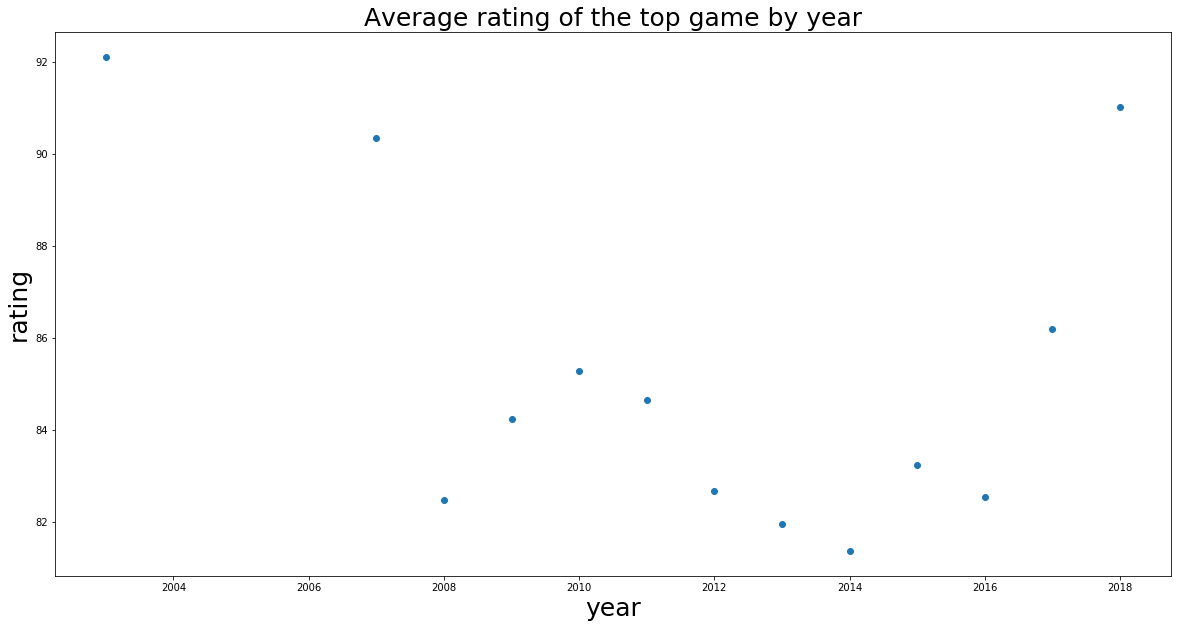

In [90]:
new_figure = plt.figure(figsize=(20,10))
ax = new_figure.add_subplot(111)
ax.scatter(release_year_mean.index , release_year_mean.total_review_rating)
ax.set_xlabel('year', size=25)
ax.set_ylabel('rating', size=25)
ax.set_title('Average rating of the top game by year', size=25)